In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import matplotlib.pyplot as plt
from time import sleep
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import the excel source file to pandas
df=pd.read_excel(r"C:\Users\user\OneDrive - Luleå University of Technology\TMUTA 2024-2025\D7015B- Industrial AI and eMaintenance\Assignment_3\train_delays_v.1.xlsx", index_col=0)
df = df.reset_index(drop=True)
df.head(2)

,Train ID,Year,Date,Operator,Place,Train mission,Tågnr,Route,Route number,Reason code,Reason code - level 1,Reason code Level 2,Reason code Level 3,registered delay,Train number
0,2018-01-017123,2018,2018-01-01,Svenska Tågkompaniet AB,Storsund,7123,7123,LE-UÅ,3165,JJF -,Järnvägsföretag,Ingen uppgift från JF,-,3,F0942
1,2018-01-017123,2018,2018-01-01,Svenska Tågkompaniet AB,Vännäs,7123,7123,LE-UÅ,3165,JTP -,Järnvägsföretag,Terminal/Plattform-hantering,-,5,F0942


In [2]:
df.dtypes

Train ID                 object
Year                      int64
Date                     object
Operator                 object
Place                    object
Train mission             int64
Tågnr                     int64
Route                    object
Route number              int64
Reason code              object
Reason code - level 1    object
Reason code Level 2      object
Reason code Level 3      object
registered delay          int64
Train number             object
dtype: object

In [3]:
df["Date"]=pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['month']=df['Date'].dt.month
df['day']=df['Date'].dt.day

In [7]:
df['day_of_week'] = df['Date'].dt.day_name()  # Returns 'Monday', 'Tuesday', etc.
df['day_of_week_num'] = df['Date'].dt.dayofweek  # Returns 0 (Monday) to 6 (Sunday)
df['is_punctual'] = (df['registered delay'] <= 5).astype(int)
df['route_length'] = df['Route'].apply(lambda x: len(str(x)))
df['is_weekend'] = (df['day_of_week_num'] >= 5).astype(int)



In [8]:
# Define astronomical season function for 2018-2020
def get_astronomical_season(date):
    if pd.isna(date):
        return None
    
    year = date.year
    date_str = date.strftime('%Y-%m-%d')
    
    seasons = {
        2018: {
            'Winter': ('2017-12-21', '2018-03-20'),
            'Spring': ('2018-03-20', '2018-06-21'),
            'Summer': ('2018-06-21', '2018-09-22'),
            'Autumn': ('2018-09-22', '2018-12-21'),
            'Winter_next': ('2018-12-21', '2019-03-20')
        },
        2019: {
            'Winter': ('2018-12-21', '2019-03-20'),
            'Spring': ('2019-03-20', '2019-06-21'),
            'Summer': ('2019-06-21', '2019-09-23'),
            'Autumn': ('2019-09-23', '2019-12-22'),
            'Winter_next': ('2019-12-22', '2020-03-19')
        },
        2020: {
            'Winter': ('2019-12-22', '2020-03-19'),
            'Spring': ('2020-03-19', '2020-06-20'),
            'Summer': ('2020-06-20', '2020-09-22'),
            'Autumn': ('2020-09-22', '2020-12-21'),
            'Winter_next': ('2020-12-21', '2021-03-20')
        }
    }
    
    if year not in seasons:
        return None
    
    year_seasons = seasons[year]
    for season, (start, end) in year_seasons.items():
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        if start_date <= date < end_date:
            if season.endswith('_next'):
                return 'Winter'
            return season
    return 'Winter'

# Apply season
df['season'] = df['Date'].apply(get_astronomical_season)

# Verify (optional)
print(df[['Date', 'season']].head(10))

        Date  season
0 2018-01-01  Winter
1 2018-01-01  Winter
2 2018-01-01  Winter
3 2018-01-01  Winter
4 2018-01-01  Winter
5 2018-01-01  Winter
6 2018-01-01  Winter
7 2018-01-01  Winter
8 2018-01-01  Winter
9 2018-01-01  Winter


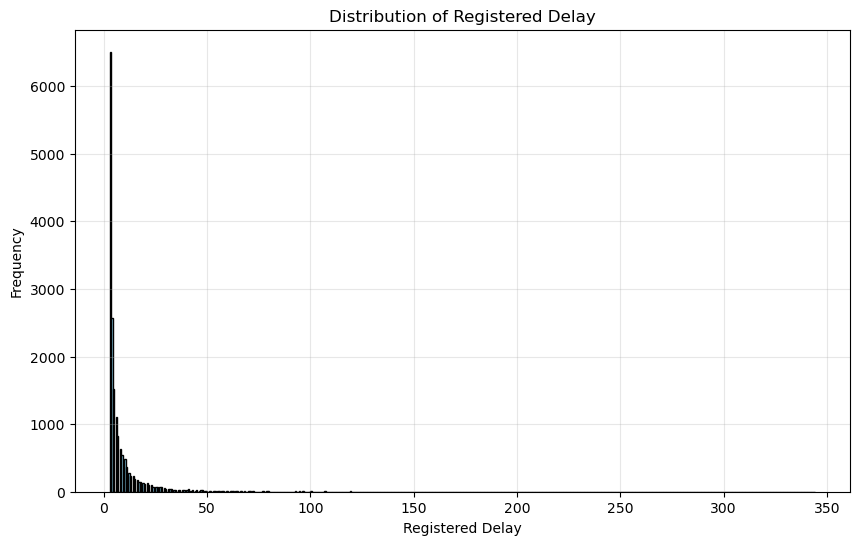

2.5% of 'registered delay' data is below 3.00
97.5% of 'registered delay' data is below 45.00
Range containing 97.5% of data (2.5th to 97.5th percentile): 3.00 to 45.00


In [9]:
# Histogram of 'registered delay'
plt.figure(figsize=(10, 6))
plt.hist(df['registered delay'], bins=500, edgecolor='black', color='skyblue')
plt.title('Distribution of Registered Delay')
plt.xlabel('Registered Delay')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
# Calculate percentiles for a one-sided distribution
lower_bound = np.percentile(df['registered delay'], 2.5)  # 2.5th percentile (optional lower reference)
upper_bound = np.percentile(df['registered delay'], 97.5)  # 97.5th percentile (90% below this
# Print the results
print(f"2.5% of 'registered delay' data is below {lower_bound:.2f}")
print(f"97.5% of 'registered delay' data is below {upper_bound:.2f}")
print(f"Range containing 97.5% of data (2.5th to 97.5th percentile): {lower_bound:.2f} to {upper_bound:.2f}")

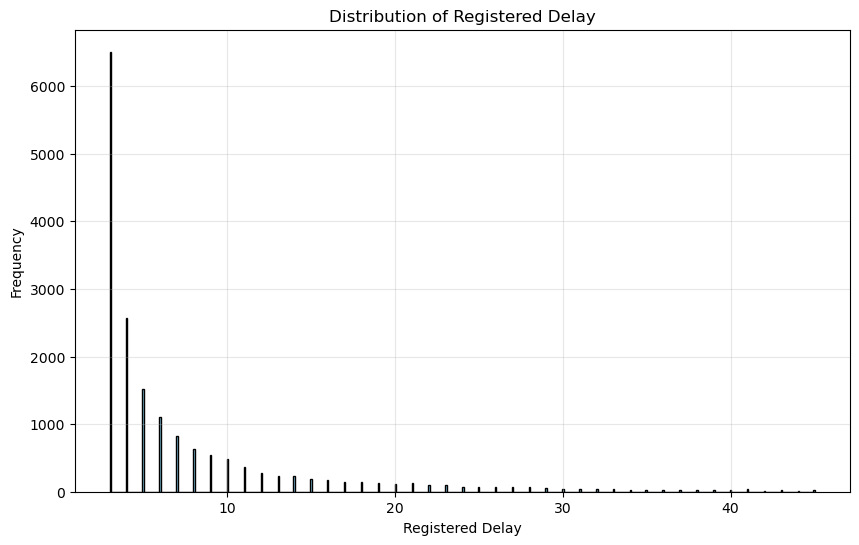

In [10]:
df = df[df['registered delay'] < 46] #removing outliers more than 45 mins. 
# Histogram of 'registered delay'
plt.figure(figsize=(10, 6))
plt.hist(df['registered delay'], bins=500, edgecolor='black', color='skyblue')
plt.title('Distribution of Registered Delay')
plt.xlabel('Registered Delay')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

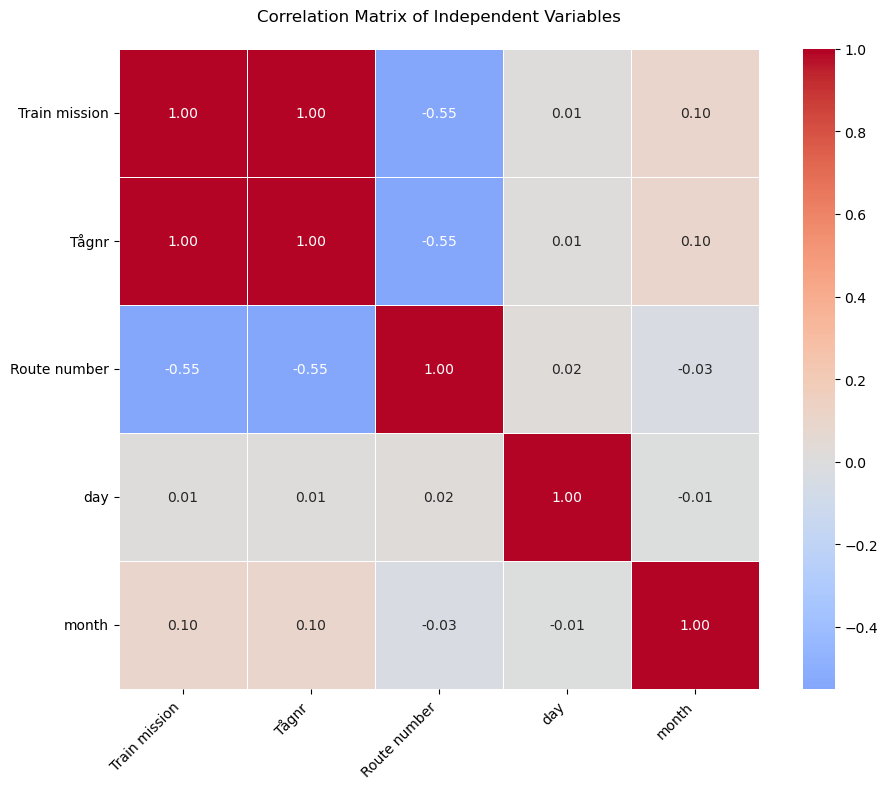


Correlation Matrix:
               Train mission     Tågnr  Route number       day     month
Train mission       1.000000  0.997299     -0.551366  0.008706  0.098100
Tågnr               0.997299  1.000000     -0.548965  0.008462  0.100069
Route number       -0.551366 -0.548965      1.000000  0.019223 -0.032986
day                 0.008706  0.008462      0.019223  1.000000 -0.005675
month               0.098100  0.100069     -0.032986 -0.005675  1.000000


In [11]:
# Calculate correlation matrix
X = df[['Train mission', 'Tågnr', 'Route number', 'day', 'month']]
correlation_matrix = X.corr()

# Create a heatmap visualization
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(correlation_matrix, 
            annot=True,          # Show correlation values in cells
            cmap='coolwarm',     # Color scheme
            center=0,           # Center the colormap at 0
            fmt='.2f',          # Format numbers to 2 decimal places
            square=True,        # Make the plot square-shaped
            linewidths=0.5)     # Width of lines between cells

# Customize the plot
plt.title('Correlation Matrix of Independent Variables', pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)               # Keep y labels horizontal

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Print the correlation matrix as a table
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [12]:
df=df.drop(['Tågnr','Train ID','Operator','Reason code - level 1'],axis=1)
df.head(2)

,Year,Date,Place,Train mission,Route,Route number,Reason code,Reason code Level 2,Reason code Level 3,registered delay,Train number,month,day,day_of_week,day_of_week_num,is_punctual,route_length,is_weekend,season
0,2018,2018-01-01,Storsund,7123,LE-UÅ,3165,JJF -,Ingen uppgift från JF,-,3,F0942,1,1,Monday,0,1,5,0,Winter
1,2018,2018-01-01,Vännäs,7123,LE-UÅ,3165,JTP -,Terminal/Plattform-hantering,-,5,F0942,1,1,Monday,0,1,5,0,Winter


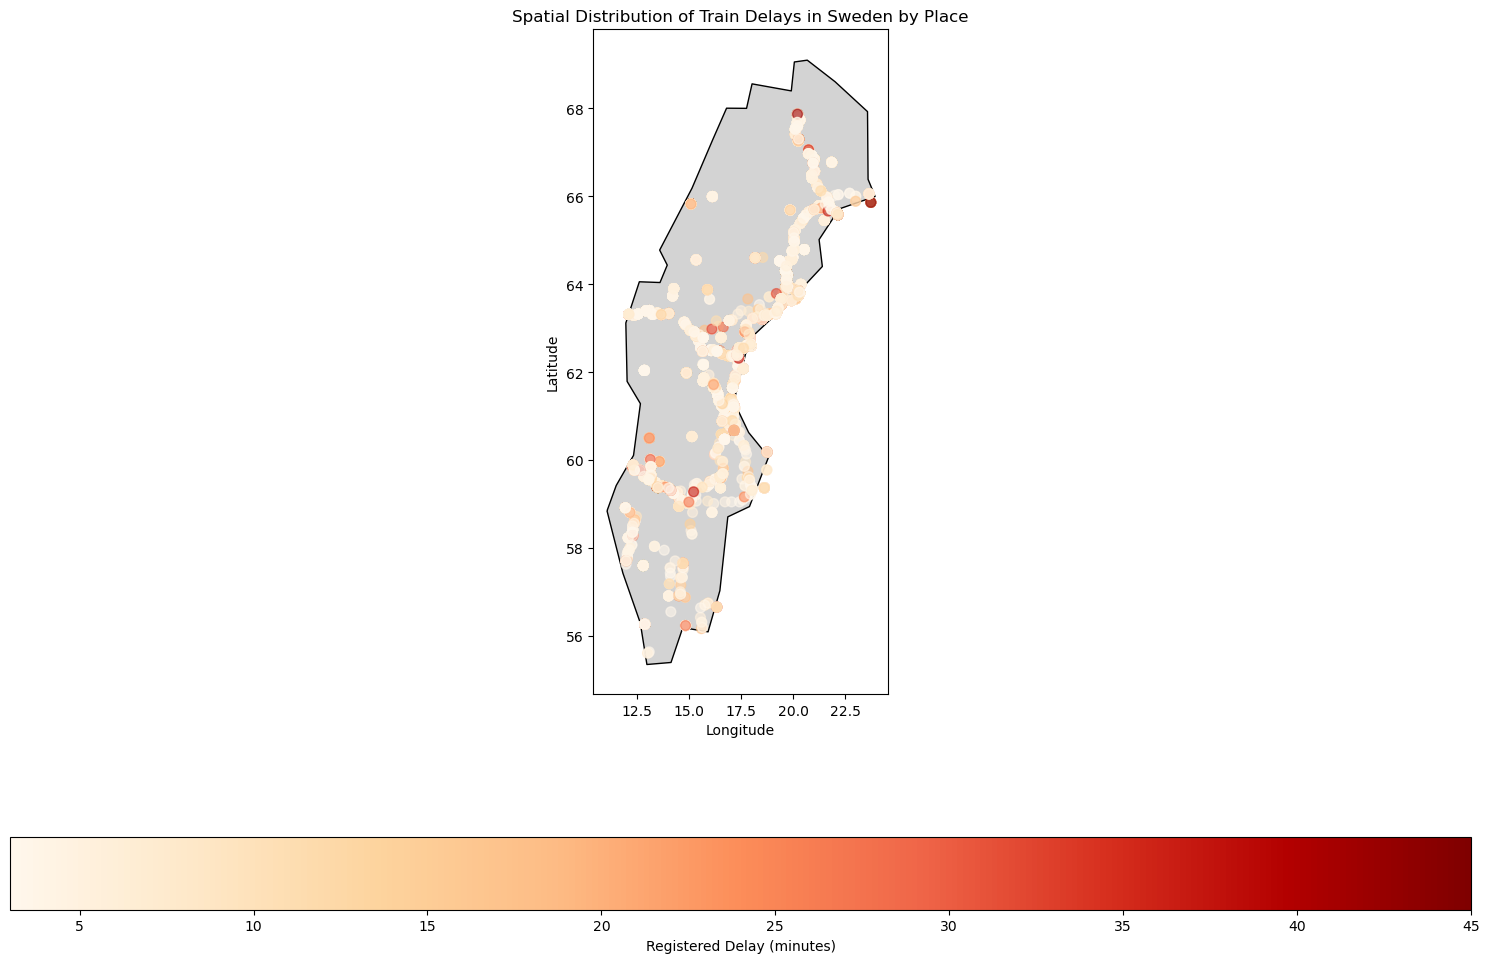

In [10]:
# Initialize the geocoder (using OpenStreetMap Nominatim)
geolocator = Nominatim(user_agent="train_delays_analysis")

# Function to get latitude and longitude for a place
def get_coordinates(place):
    try:
        location = geolocator.geocode(place + ", Sweden")  # Assuming all places are in Sweden
        if location:
            return location.latitude, location.longitude
        return None, None
    except Exception as e:
        print(f"Error geocoding {place}: {e}")
        return None, None

# Get unique places and fetch coordinates (with rate limiting)
unique_places = df['Place'].unique()
coordinates = {}
for place in unique_places:
    lat, lon = get_coordinates(place)
    coordinates[place] = (lat, lon)
    sleep(1)  # Wait 1 second to avoid rate limits

# Add latitude and longitude to the DataFrame
df['latitude'] = df['Place'].map(lambda x: coordinates[x][0])
df['longitude'] = df['Place'].map(lambda x: coordinates[x][1])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Load the Natural Earth shapefile using pyogrio engine
world = gpd.read_file(r"C:\Users\user\OneDrive - Luleå University of Technology\TMUTA 2024-2025\D7015B- Industrial AI and eMaintenance\Assignment_3\110m_cultural\ne_110m_admin_0_countries.shp", engine="pyogrio")
sweden = world[world['ADMIN'] == 'Sweden']

# Plot the data spatially
fig, ax = plt.subplots(figsize=(15, 10))
sweden.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf[gdf['geometry'].notnull()].plot(ax=ax, column='registered delay', cmap='OrRd', legend=True, 
         markersize=50, alpha=0.6, legend_kwds={'label': "Registered Delay (minutes)", 'orientation': "horizontal"})
plt.title('Spatial Distribution of Train Delays in Sweden by Place')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


In [31]:
# Keep all rows, even if coordinates couldn't be fetched
# Create geometry points for GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']) if pd.notnull(row['longitude']) and pd.notnull(row['latitude']) else None, axis=1)

# Drop rows where 'geometry' is NaN/None
df.dropna(subset=['geometry'], inplace=True)

# Reset the index if needed (optional)
df = df.reset_index(drop=True)

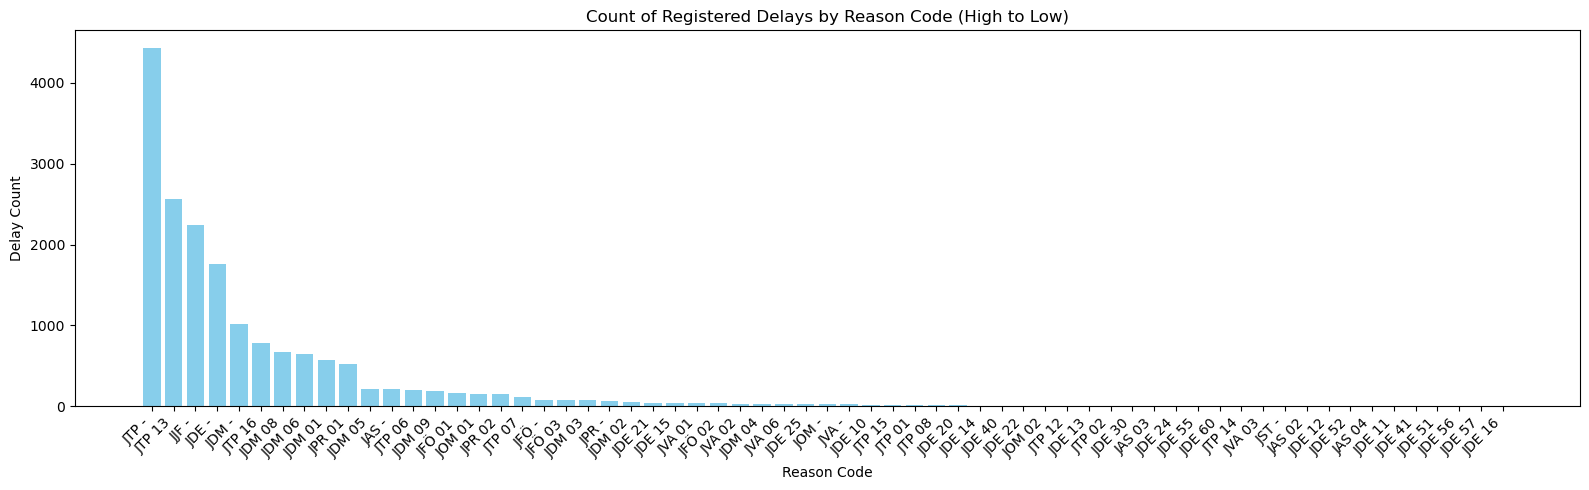

In [12]:
# Group by 'ReasonCode' and count the number of entries in 'registered_delay'
delay_counts = df.groupby('Reason code')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Reason code', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(16, 5))  # Adjust figure size for readability
plt.bar(delay_counts['Reason code'], delay_counts['delay_count'], color='skyblue')

# Customize the plot
plt.xlabel('Reason Code')
plt.ylabel('Delay Count')
plt.title('Count of Registered Delays by Reason Code (High to Low)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Display the plot
plt.show()


                Place  delay_count
301       Sundsvall c          760
335              Umeå          718
336  Umeå godsbangård          582
147        Karlstad C          555
239           Ockelbo          452
..                ...          ...
314          Tallåsen            1
158         Klevshult            1
77             Gnesta            1
78             Gottne            1
205           Malmö c            1

[390 rows x 2 columns]


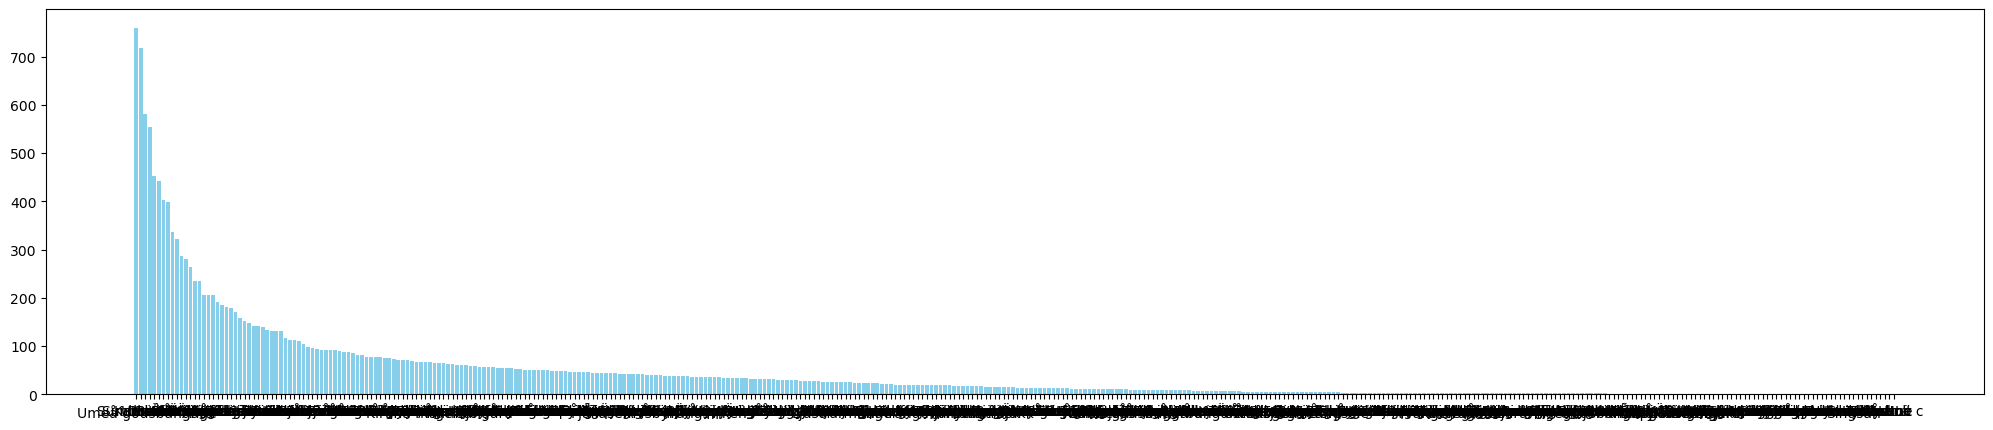

In [13]:
# Group by 'Place' and count the number of entries in 'registered delay'
delay_counts = df.groupby('Place')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Place', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(25, 5))  # Adjust figure size for readability
plt.bar(delay_counts['Place'], delay_counts['delay_count'], color='skyblue')
# Print the top 10 places
print(delay_counts)

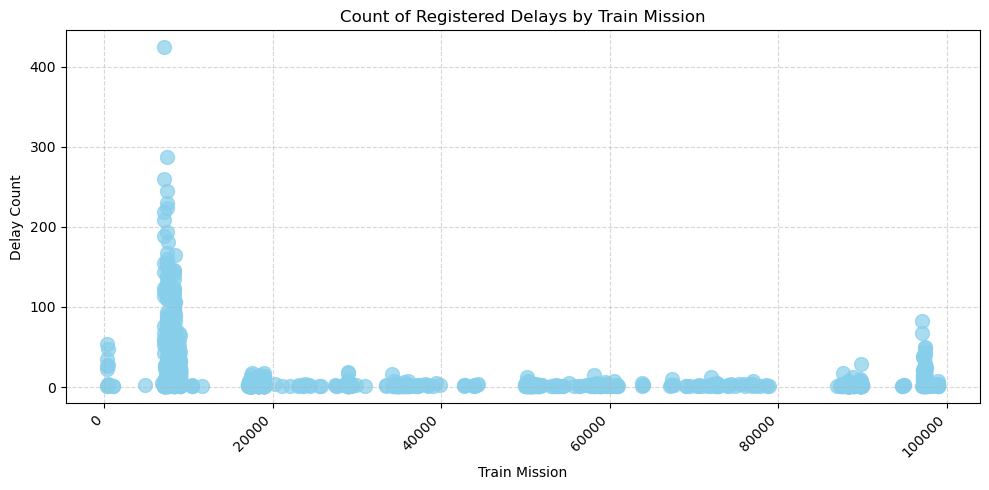

In [14]:
# Group by 'ReasonCode' and count the number of entries in 'registered_delay'
delay_counts = df.groupby('Train mission')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Train mission', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a scatter plot
plt.figure(figsize=(10, 5))  # Adjust figure size for readability
plt.scatter(delay_counts['Train mission'], delay_counts['delay_count'], color='skyblue', s=100, alpha=0.7)

# Customize the plot
plt.xlabel('Train Mission')
plt.ylabel('Delay Count')
plt.title('Count of Registered Delays by Train Mission')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True, linestyle='--', alpha=0.5)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Display the plot
plt.show()



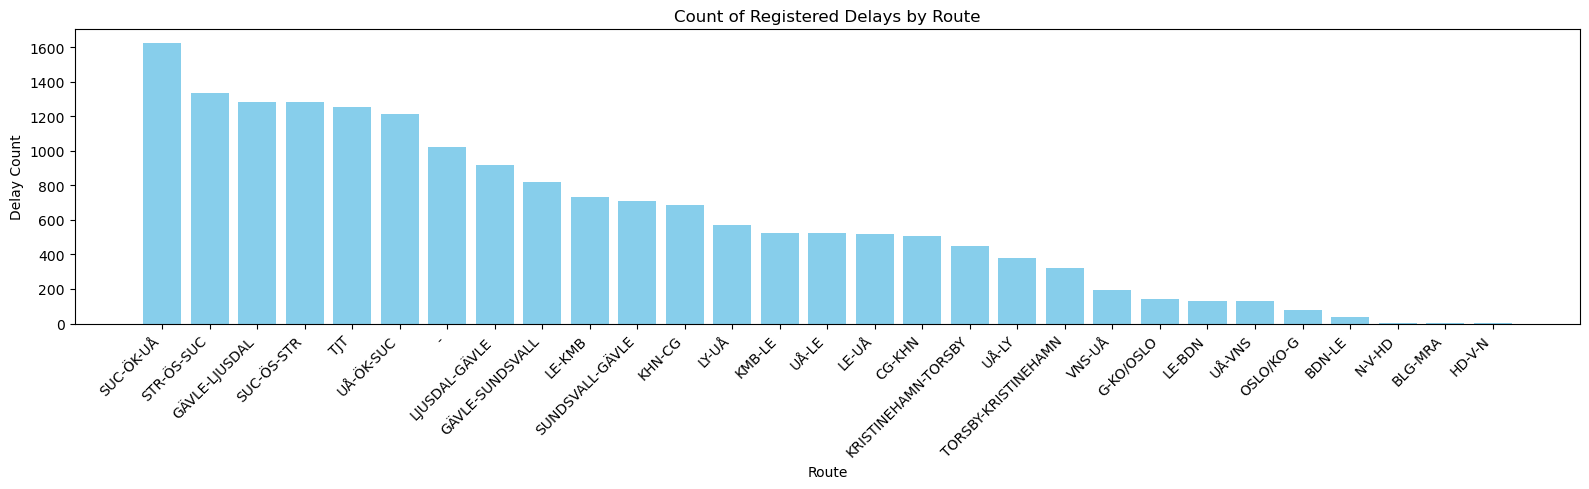

In [15]:
# Group by 'ReasonCode' and count the number of entries in 'registered_delay'
delay_counts = df.groupby('Route')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Route', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(16, 5))  # Adjust figure size for readability
plt.bar(delay_counts['Route'], delay_counts['delay_count'], color='skyblue')

# Customize the plot
plt.xlabel('Route')
plt.ylabel('Delay Count')
plt.title('Count of Registered Delays by Route')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Display the plot
plt.show()

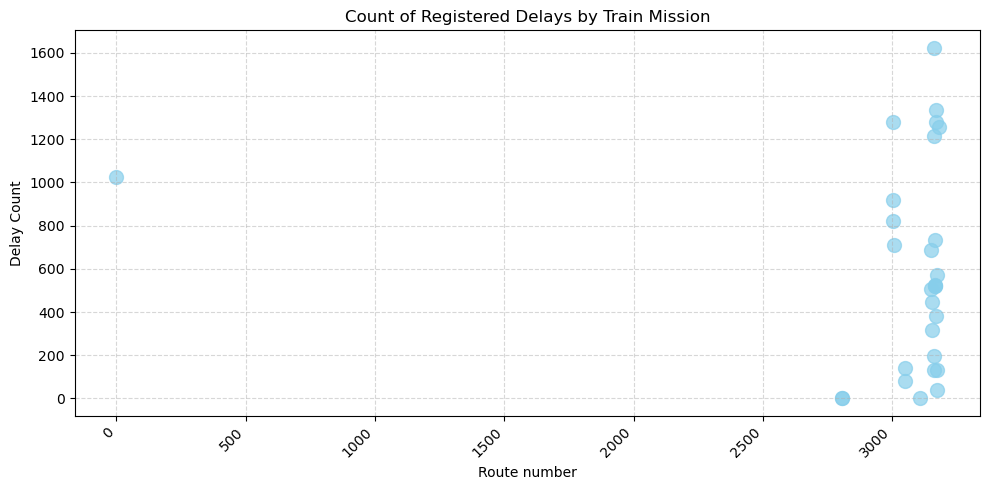

In [16]:
# Group by 'ReasonCode' and count the number of entries in 'registered_delay'
delay_counts = df.groupby('Route number')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Route number', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a scatter plot
plt.figure(figsize=(10, 5))  # Adjust figure size for readability
plt.scatter(delay_counts['Route number'], delay_counts['delay_count'], color='skyblue', s=100, alpha=0.7)

# Customize the plot
plt.xlabel('Route number')
plt.ylabel('Delay Count')
plt.title('Count of Registered Delays by Train Mission')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True, linestyle='--', alpha=0.5)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
# Display the plot
plt.show()

            Reason code Level 2  delay_count
8  Terminal/Plattform-hantering         8117
1        Dragfordon / motorvagn         3463
3         Ingen uppgift från JF         2246
6                Sent från depå         1945
5                  Prioritering          742
2                 Förarpersonal          351
0      Avvikande sammansättning          222
4                Ombordpersonal          188
9                          Vagn          128
7            Stationär personal            2


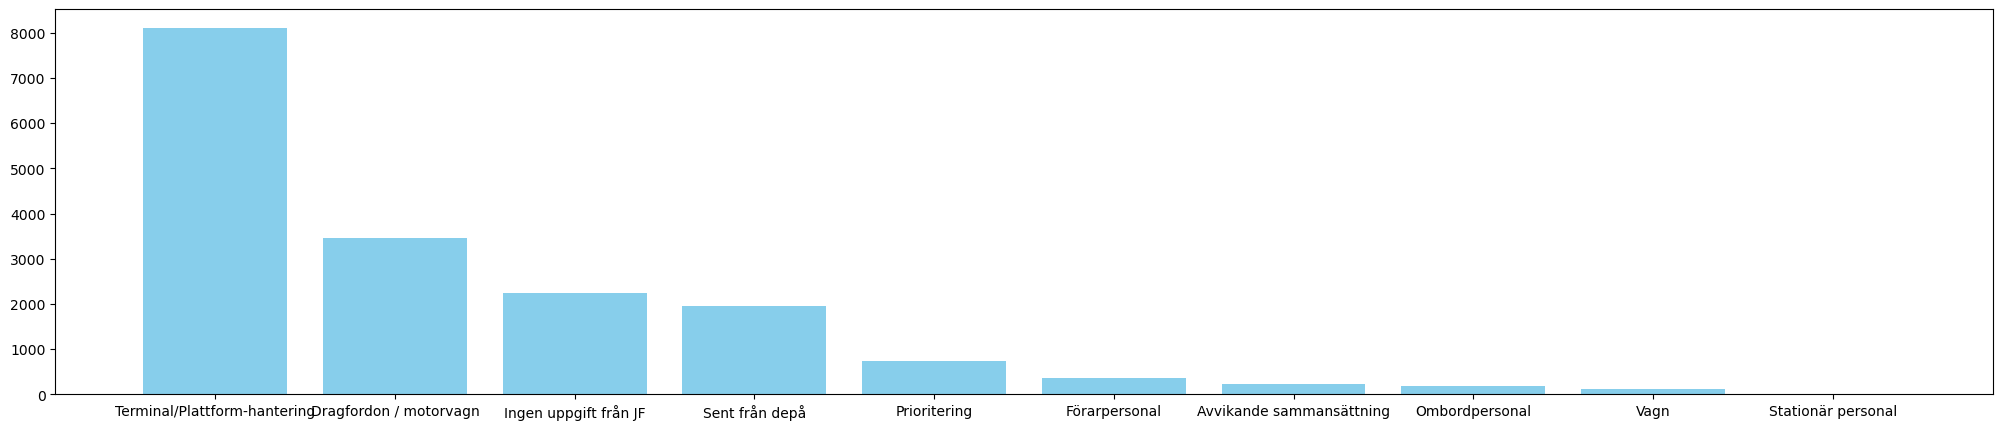

In [17]:
# Group by 'Place' and count the number of entries in 'registered delay'
delay_counts = df.groupby('Reason code Level 2')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Reason code Level 2', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(25, 5))  # Adjust figure size for readability
plt.bar(delay_counts['Reason code Level 2'], delay_counts['delay_count'], color='skyblue')
# Print the top 10 places
print(delay_counts)

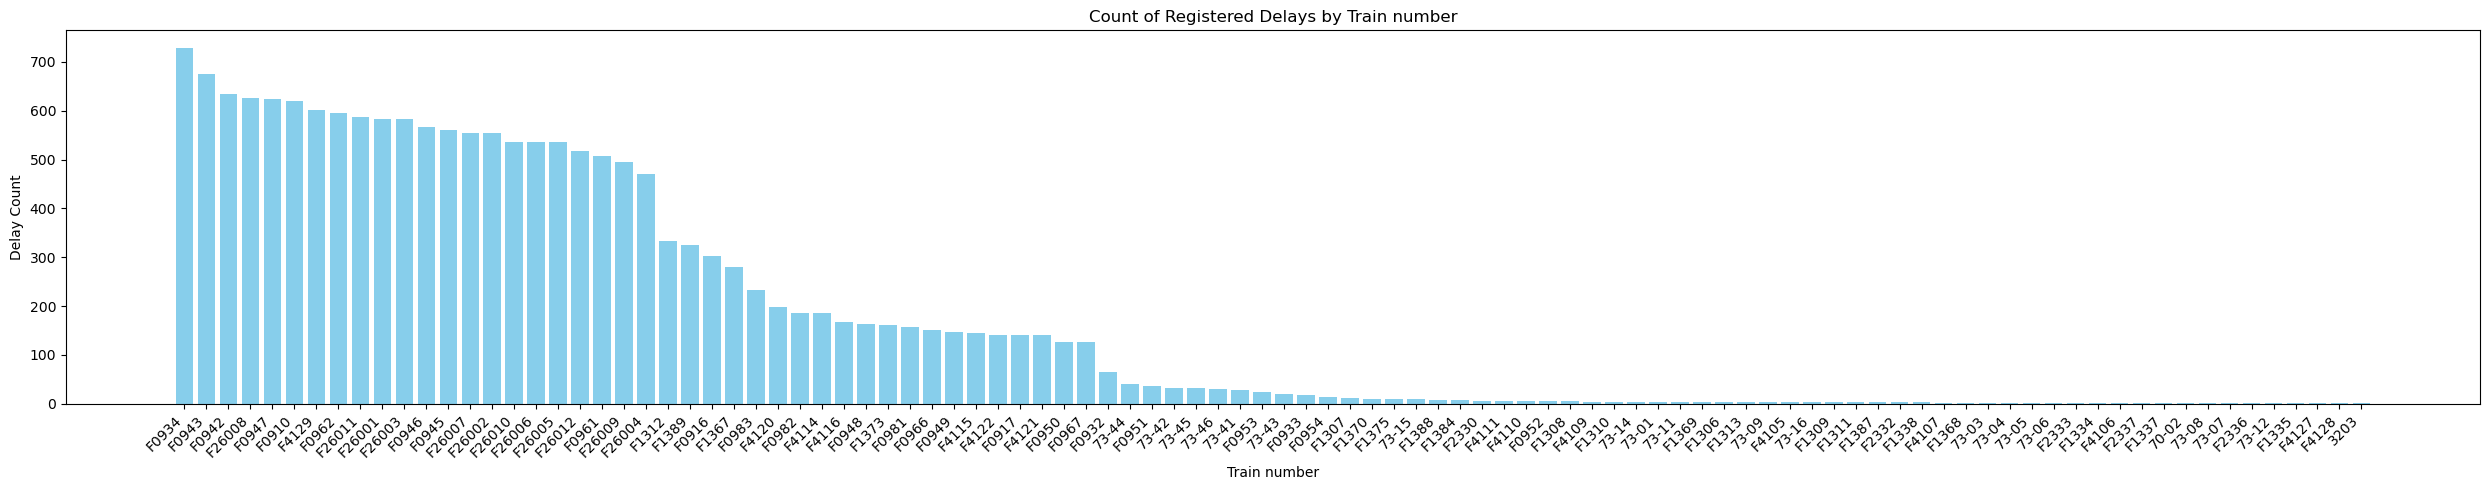

In [18]:
# Group by 'ReasonCode' and count the number of entries in 'registered_delay'
delay_counts = df.groupby('Train number')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Train number', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(25,5))  # Adjust figure size for readability
plt.bar(delay_counts['Train number'], delay_counts['delay_count'], color='skyblue')

# Customize the plot
plt.xlabel('Train number')
plt.ylabel('Delay Count')
plt.title('Count of Registered Delays by Train number')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Display the plot
plt.show()

In [32]:
df.isnull().sum()

Year                           0
Date                           0
Place                          0
Train mission                  0
Route                          0
Route number                   0
Reason code                    0
Reason code Level 2            0
Reason code Level 3            0
registered delay               0
Train number                   0
month                          0
day                            0
day_of_week                    0
day_of_week_num                0
season                         0
latitude                       0
longitude                      0
geometry                       0
Place_Encoded                  0
Reason code Level 2_Encoded    0
Reason code_Encoded            0
Reason code Level 3_Encoded    0
Route_Encoded                  0
Train number_Encoded           0
day_of_week_Encoded            0
season_Encoded                 0
dtype: int64

In [33]:
df.head()

,Year,Date,Place,Train mission,Route,Route number,Reason code,Reason code Level 2,Reason code Level 3,registered delay,...,longitude,geometry,Place_Encoded,Reason code Level 2_Encoded,Reason code_Encoded,Reason code Level 3_Encoded,Route_Encoded,Train number_Encoded,day_of_week_Encoded,season_Encoded
0,2018,2018-01-01,Storsund,7123,LE-UÅ,3165,JJF -,Ingen uppgift från JF,Still a reason has not been assigned,3,...,20.625469,POINT (20.6254692 65.5765944),4.846154,4.034169,4.034169,5.844264,7.911708,8.321260,7.495248,7.925156
1,2018,2018-01-01,Vännäs,7123,LE-UÅ,3165,JTP -,Terminal/Plattform-hantering,Still a reason has not been assigned,5,...,19.666667,POINT (19.666667 63.95),7.843636,6.775574,4.301591,5.844264,7.911708,8.321260,7.495248,7.925156
2,2018,2018-01-01,Kirunavaara,7165,KMB-LE,3167,JJF -,Ingen uppgift från JF,Still a reason has not been assigned,4,...,20.201096,POINT (20.2010961 67.8018015),4.416667,4.034169,4.034169,5.844264,7.802682,7.218284,7.495248,7.925156
3,2018,2018-01-01,Gimonäs,7410,SUC-ÖK-UÅ,3160,JDM 03,Dragfordon / motorvagn,Strömavtagare,6,...,20.309157,POINT (20.3091568 63.797276),5.384615,8.654727,9.242424,9.242424,8.418894,6.988806,7.495248,7.925156
4,2018,2018-01-01,Stöcke,7410,SUC-ÖK-UÅ,3160,JDM 03,Dragfordon / motorvagn,Strömavtagare,4,...,20.231426,POINT (20.231426 63.7425592),8.461538,8.654727,9.242424,9.242424,8.418894,6.988806,7.495248,7.925156


In [34]:
print('\n'.join(df.columns.tolist()))

Year
Date
Place
Train mission
Route
Route number
Reason code
Reason code Level 2
Reason code Level 3
registered delay
Train number
month
day
day_of_week
day_of_week_num
season
latitude
longitude
geometry
Place_Encoded
Reason code Level 2_Encoded
Reason code_Encoded
Reason code Level 3_Encoded
Route_Encoded
Train number_Encoded
day_of_week_Encoded
season_Encoded


In [35]:
df = df.dropna(subset=['Train number'], axis=0)
# Replace '-', NaN, and empty strings with 'Still a reason has not been assigned'
df['Reason code Level 3'] = df['Reason code Level 3'].replace(['-', '', None, pd.NA, float('nan')], 'Still a reason has not been assigned')

                                  Reason code Level 3  delay_count
36               Still a reason has not been assigned         9606
19                                        JF önskemål         2501
18                     Inväntad förbindelse buss/taxi          778
25                                          Maskinfel          658
26                                  Omstart av system          648
0                                             ATC-fel          569
6   Ett JF har bestämt prioriteringen mellan egna tåg          526
3                                            Bromsfel          246
5                                             Dörrfel          224
46                             Växlingsrörelse ivägen          192


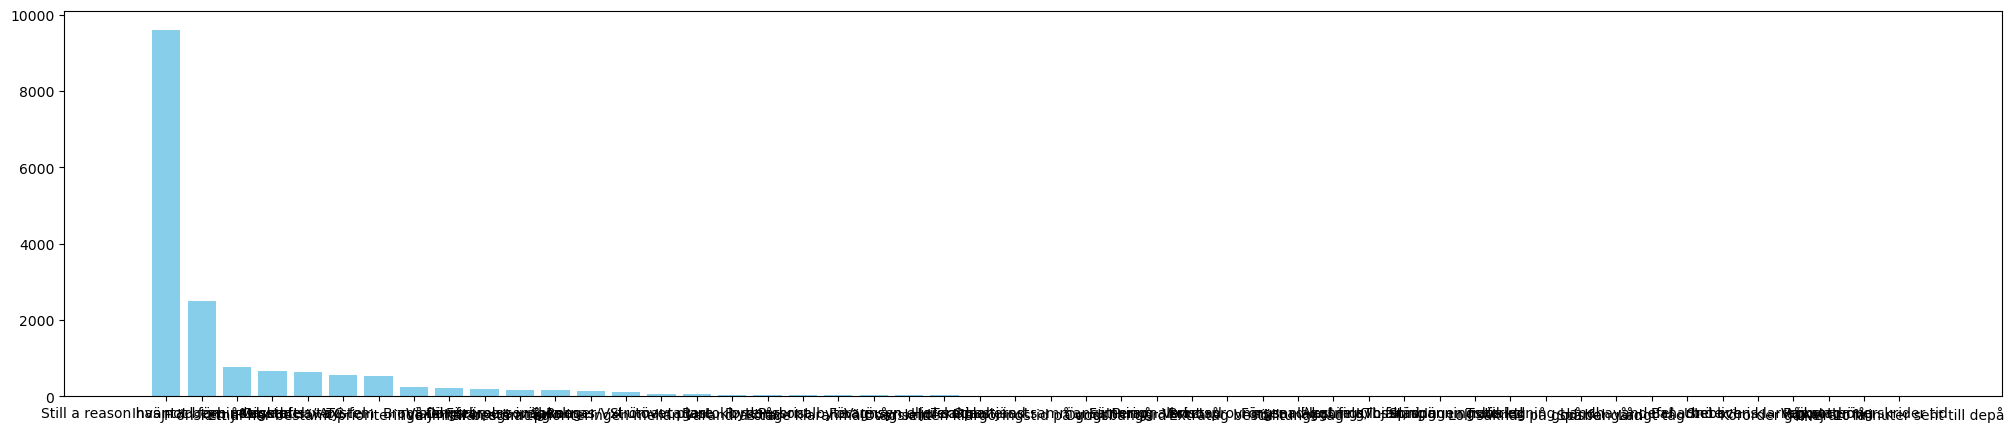

In [23]:
# Group by 'Place' and count the number of entries in 'registered delay'
delay_counts = df.groupby('Reason code Level 3')['registered delay'].count().reset_index()

# Rename the columns for clarity
delay_counts.columns = ['Reason code Level 3', 'delay_count']

# Sort by 'delay_count' from high to low
delay_counts = delay_counts.sort_values(by='delay_count', ascending=False)

# Create a bar plot
plt.figure(figsize=(25, 5))  # Adjust figure size for readability
plt.bar(delay_counts['Reason code Level 3'], delay_counts['delay_count'], color='skyblue')
# Print the top 10 places
print(delay_counts.head(10))

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Selecting features (X) and target variable (Y)
X = df[['day', 'month', 'Train mission', 'Route number', 'day_of_week_num']]
y = df['registered delay']

# Add constant for intercept in statsmodels
X = sm.add_constant(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute R-squared and Adjusted R-squared manually
r_squared = r2_score(y_test, y_pred)
n = len(y_test)  # Number of samples
p = X_train.shape[1] - 1  # Number of predictors (excluding constant)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Print performance metrics
print("\nModel Performance:")
print(f"R-squared (R²): {r_squared:.4f}")
print(f"Adjusted R-squared (Adj R²): {adj_r_squared:.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Predict delay for new data
# Add day_of_week_num (e.g., 1 for Tuesday, a common weekday)
new_data = pd.DataFrame({'const': 1, 'day': [15], 'month': [3], 'Train mission': [105], 'Route number': [2], 'day_of_week_num': [1]})
predicted_delay = model.predict(new_data)
print("\nPredicted registered delay:", predicted_delay[0])


                            OLS Regression Results                            
Dep. Variable:       registered delay   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     27.68
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           5.50e-28
Time:                        11:27:21   Log-Likelihood:                -46172.
No. Observations:               13612   AIC:                         9.236e+04
Df Residuals:                   13606   BIC:                         9.240e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.1124      0.392     

In [29]:
df.isnull().sum()

Year                             0
Date                             0
Place                            0
Train mission                    0
Route                            0
Route number                     0
Reason code                      0
Reason code Level 2              0
Reason code Level 3              0
registered delay                 0
Train number                     0
month                            0
day                              0
day_of_week                      0
day_of_week_num                  0
season                           0
latitude                         0
longitude                        0
geometry                       226
Place_Encoded                    0
Reason code Level 2_Encoded      0
Reason code_Encoded              0
Reason code Level 3_Encoded      0
Route_Encoded                    0
Train number_Encoded             0
day_of_week_Encoded              0
season_Encoded                   0
dtype: int64

In [30]:
df.head(2)

,Year,Date,Place,Train mission,Route,Route number,Reason code,Reason code Level 2,Reason code Level 3,registered delay,...,longitude,geometry,Place_Encoded,Reason code Level 2_Encoded,Reason code_Encoded,Reason code Level 3_Encoded,Route_Encoded,Train number_Encoded,day_of_week_Encoded,season_Encoded
0,2018,2018-01-01,Storsund,7123,LE-UÅ,3165,JJF -,Ingen uppgift från JF,Still a reason has not been assigned,3,...,20.625469,POINT (20.6254692 65.5765944),4.846154,4.034169,4.034169,5.844264,7.911708,8.32126,7.495248,7.925156
1,2018,2018-01-01,Vännäs,7123,LE-UÅ,3165,JTP -,Terminal/Plattform-hantering,Still a reason has not been assigned,5,...,19.666667,POINT (19.666667 63.95),7.843636,6.775574,4.301591,5.844264,7.911708,8.32126,7.495248,7.925156


In [13]:
# Define target and predictors
target_column = 'registered delay'
numerical_predictors = ['day', 'month', 'Train mission', 'Route number','is_punctual','route_length','is_weekend']
categorical_columns = ['Place', 'Reason code Level 2', 'Reason code', 
                      'Reason code Level 3', 'Route', 'Train number', 'day_of_week']

# Apply target encoding
for cat_col in categorical_columns:
    mapping_dict = df.groupby(cat_col)[target_column].mean().to_dict()
    df[f"{cat_col}_Encoded"] = df[cat_col].map(mapping_dict)

# Prepare feature set
X = df[numerical_predictors + [f"{col}_Encoded" for col in categorical_columns]]
y = df[target_column]

# Handle missing values
X = X.dropna()
y = y.loc[X.index]

# Add constant
X = sm.add_constant(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Predict and evaluate
y_pred = model.predict(X_test)
print("\nModel Performance:")
print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")
print(f"Adjusted R-squared (Adj R²): {1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_train.shape[1] + 1)):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Predict new data
new_data = pd.DataFrame({
    'const': [1], 'day': [15], 'month': [3], 'Train mission': [105], 'Route number': [2],
    'Place_Encoded': [df['Place_Encoded'].mean()],
    'Reason code Level 2_Encoded': [df['Reason code Level 2_Encoded'].mean()],
    'Reason code_Encoded': [df['Reason code_Encoded'].mean()],
    'Reason code Level 3_Encoded': [df['Reason code Level 3_Encoded'].mean()],
    'Route_Encoded': [df['Route_Encoded'].mean()],
    'Train number_Encoded': [df['Train number_Encoded'].mean()],
    'day_of_week_Encoded': [df['day_of_week_Encoded'].mean()]
}, columns=X_train.columns)  # Ensure column match

predicted_delay = model.predict(new_data)
print("\nPredicted registered delay:", predicted_delay.iloc[0])

                            OLS Regression Results                            
Dep. Variable:       registered delay   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     910.2
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:45:49   Log-Likelihood:                -41740.
No. Observations:               13612   AIC:                         8.351e+04
Df Residuals:                   13597   BIC:                         8.362e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             